<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/preprocessing/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendendo o problema de predição de saude da aeronave

Objetivos:

* Separar duas aeronaves para o teste final 
* Selecionar duas das séries para analisar dentro das aeronaves de treino
* Visualizar e realizar o preprocessamento dos dados
* Aplicar um modelo de predição usando uma para treinar e outra para testar

In [4]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos')

Estou rodando no Colab (S/N)?
s
Mounted at /content/drive


## Tratamento e organização inicial dos dados

In [5]:
#bibliotecas de manipulação de dados
import pandas as pd
import numpy as np

#visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import matplotlib.gridspec as gridspec
from ast import literal_eval

#pré processamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#métricas de avaliação dos modelos.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

### Importação dos dados

In [6]:
#importando direto do github
data_feat = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/caracteristica.csv')
data_health = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/tcc_pes/main/data/saude.csv')

### Tratamento inicial dos dados
* Mediana dos dias 
* Unificação dos datasets 
* Separação treino e teste final

In [7]:
# Unificação dos datasets #####

#calculando a mediana dos dados
data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_feat = data_feat.groupby(by=['COD_FALH','COD_AENV','COD_EVNT']).median().reset_index()

#Unificando os datasets 
data_health['id'] = data_health.index
data_health.head()
data_all = pd.merge(data_feat, data_health, on=['COD_EVNT','COD_FALH','COD_AENV']).sort_values('DT_PROC')


### Separação treino teste
np.random.seed(123)
np.random.randint(0,2,10)
test = np.random.choice(np.unique(data_health.COD_AENV),2)

# Treino 
data  = data_all[data_all.COD_AENV != test[0]][data_all.COD_AENV != test[1]]
print("Aviões usados para teste: ", test)


## Teste final
data_test = data_all[(data_all.COD_AENV == test[0]) | (data_all.COD_AENV == test[1])]
print("Aviões usados para validação k-fold: ", np.unique(data_health.COD_AENV))

Aviões usados para teste:  [9834 9747]
Aviões usados para validação k-fold:  [1011 9486 9526 9636 9664 9678 9747 9770 9793 9834]


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1218: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Separação das amostras

In [8]:
#aplica filtro de média móvel
def filtro(desgaste,tipo):
  if tipo == 'media_movel':
    w = 2
    desgaste_filt = np.convolve(desgaste, np.ones(w), 'valid') / w
  
  return desgaste_filt

#retorna os índices em que ocorrem as quebras
def discontinuity_filt(desgaste):
  dist = 10
  quebras = []
  desgaste_filt = filtro(desgaste,'media_movel')
  a=0
  for i in range(0,len(desgaste_filt)-1):
    if abs(desgaste_filt[i]-desgaste_filt[i+1])>dist:
      if (a == 0):
        a = 1
      else:
        quebras.append(i)   
        a = 0      
  quebras = np.array(quebras)

  return quebras

#Transforma o banco de dados em instâncias/amostras de acordo com o janela de tempo utilizada
def get_samples (data, cod_falha, look_back):
  samples=[]
  samples_day=[]
  n = look_back+10 #Tamanho (Dias) necessário da amostra

  for aircraft in np.unique(data.COD_AENV):
      air_data = data[(data.COD_AENV==aircraft)  & (data.COD_FALH==cod_falha)] #filtrando por aeronave e cod_falh
      degradation = air_data.VLR_DESG.values
      day = air_data.DT_PROC.values
      discontinuities = discontinuity_filt(degradation) #identificando as descontinuidades
      discontinuities=np.append(discontinuities, len(degradation)-1) #insere o fim do trecho
      init=0
      for i in range(0,len(discontinuities)): 
        interval_break=degradation[init:discontinuities[i]+1] #intervalo entre duas quebras
        interval_days = day[init:discontinuities[i]+1] #dias correspondentes ao intervalo 
        init=discontinuities[i]+1
        if len(interval_break)>=look_back+10: #verifica se os intervalos possuem a quantidade minima de valores
            for i in range(0,len(interval_break)-n+1): #separa os intervalos em amostras
              sample = interval_break[i:i+n].tolist() #uma amostra com n valores
              sample_day = interval_days[i:i+n].tolist() #dias correspondentes à amostra
              sample_day.append(aircraft)
              sample.append(aircraft)
              samples.append(sample)
              samples_day.append(sample_day)
      
  samples = np.array(samples)
  samples_day = np.array(samples_day)
  return  samples, samples_day 


#Normalização das amostras
def normalize_samples(samples, norm_method):
  if norm_method=="MM(-1,1)":
    scaler = MinMaxScaler(feature_range=(-1, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="MM(0,1)":
    scaler = MinMaxScaler(feature_range=(0, 1))
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  elif norm_method=="Zscore":
    scaler = StandardScaler()
    samples_scaler = scaler.fit_transform(samples)
    return samples_scaler, scaler
  else:
    return samples


#Separa as amostras em em X,Y e treino, teste
def split_train_test (samples, air_test, look_back, norm_method=False, reshape=True): 
  data_train = samples[samples[:, look_back+10] != air_test][:, 0:look_back+10] #dados de treino
  #seperação de x e y
  x_train = data_train[:,0:look_back]
  y_train = data_train[:,look_back+9]

  if air_test==False:
    if norm_method != False:
      x_train, x_scaler = normalize_samples(x_train, norm_method)
      y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)

      if reshape==True:
        x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
        y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
        return x_train, y_train, y_scaler, x_scaler

      else:
        return x_train, y_train, y_scaler, x_scaler
  
    return x_train, y_train

  data_test = samples[samples[:, look_back+10] == air_test][:, 0:look_back+10] #dados de teste
  #seperação de x e y
  x_test = data_test[:,0:look_back]
  y_test = data_test[:,look_back+9]

  #normalização de x e y
  x_train, x_scaler = normalize_samples(x_train, norm_method)
  x_test = x_scaler.transform(x_test)
  y_train, y_scaler = normalize_samples(y_train.reshape(-1, 1), norm_method)
  y_test = y_scaler.transform(y_test.reshape(-1, 1))

  #reshape para treinar os modelos recorrentes
  if reshape==True:
      x_train = np.reshape(x_train, (x_train.shape[0],1, x_train[0].shape[0])) 
      y_train = np.reshape(y_train, (y_train.shape[0],1, 1))
      x_test  = np.reshape(x_test , (x_test.shape[0], 1, x_test[0].shape[0]))
      y_test = np.reshape(y_test, (y_test.shape[0], 1,1))

  #retorna os scalers para reverter a normalização
  return x_train, y_train, x_test, y_test, y_scaler, x_scaler 


### Visualização das amostras


Text(0, 0.5, 'Desgaste (%)')

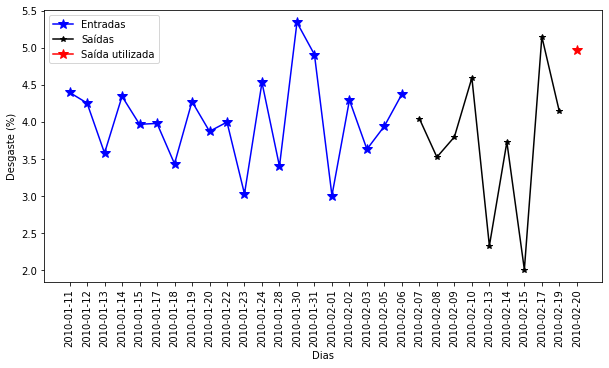

In [9]:
cod_falha = 35
look_back =20

samples, samples_day = get_samples (data, cod_falha, look_back)

x=samples[:,0:look_back] #Entradas
y_used=samples[:,look_back+9] #Saída utilizada
y=samples[:,look_back:look_back+9] #Saídas não utilizadas

x_day=samples_day[:,0:look_back] #Dias das entradas
y_used_day=samples_day[:,look_back+9] #Dia da saída utilizada
y_day=samples_day[:,look_back:look_back+9] #Dias das saídas não utilizadas

#Visualizando uma amostra
plt.figure(figsize=(10,5))
plt.plot(x_day[0], x[0], "b-*", label="Entradas", markersize=10)
plt.xticks(rotation=90)
plt.plot(y_day[0], y[0], "k-*", label="Saídas")
plt.plot(y_used_day[0], y_used[0], "r-*", label="Saída utilizada", markersize=10)
plt.legend()
plt.xlabel("Dias")
plt.ylabel("Desgaste (%)")

## Implementando ARIMA

In [10]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [33]:
samples.shape

(734, 41)

In [47]:
cod_falha = 35
look_back = 5

samples, samples_day = get_samples (data_test, cod_falha, look_back)
samples.shape

all_test =[]
all_pred = []
for i in range(0,samples.shape[0]):
  train=samples[:,0:look_back][i] #Entradas
  test=samples[:,look_back:look_back+10][i] #Saída utilizada

  model = ARIMA(train, order=(1,1,0))
  model_fit = model.fit()
  forecast = model_fit.predict(start = 10, end = 10, type='levels')
  forecast

  all_test.append(test[-1])
  all_pred.append(forecast[0])


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


3.823


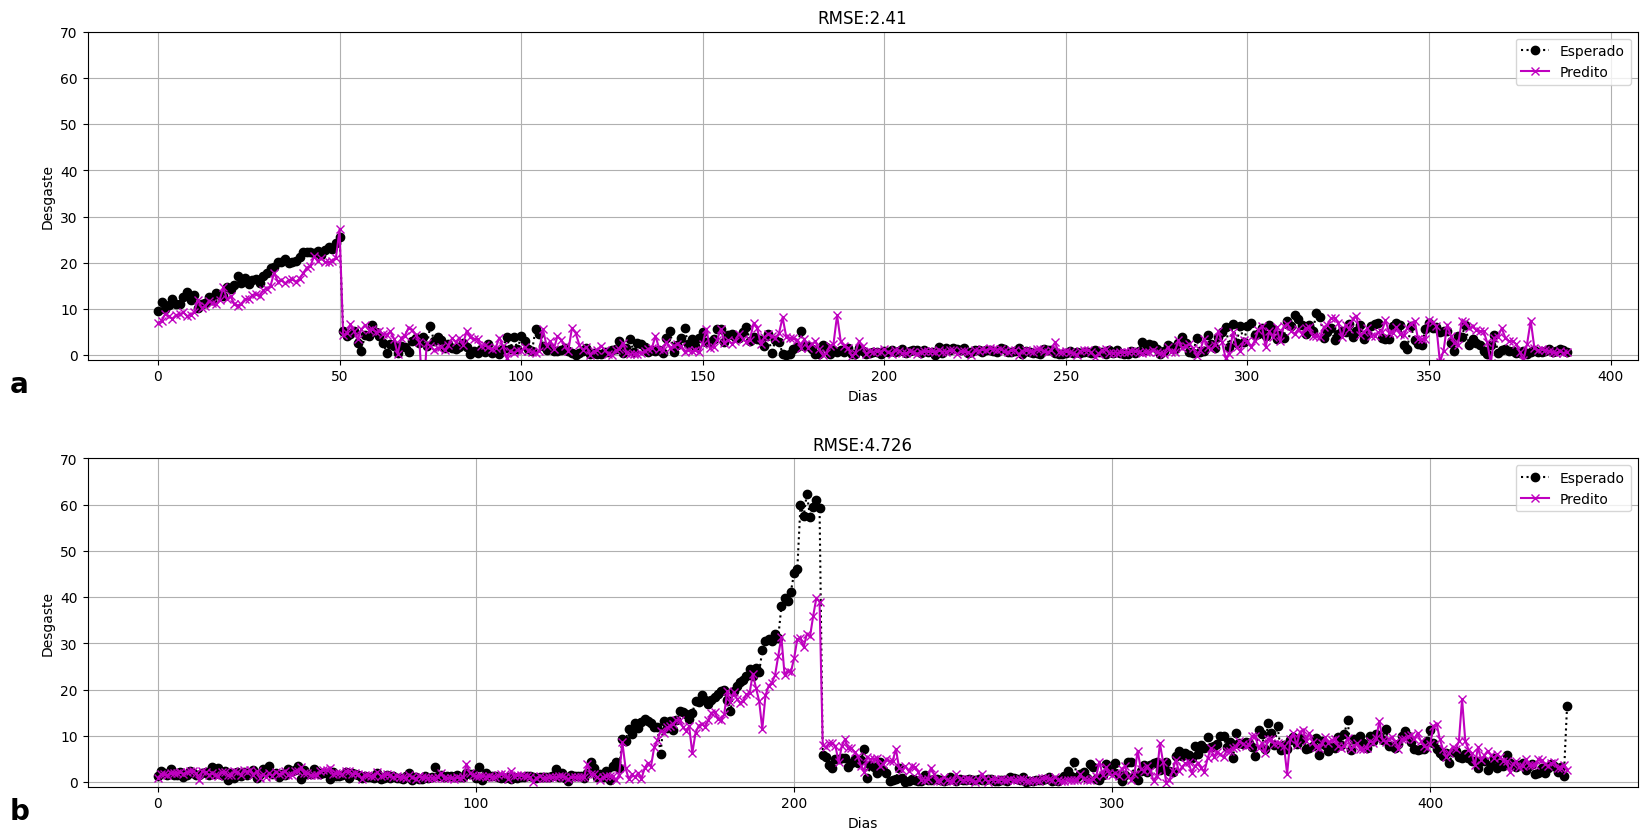

In [48]:
fig = plt.figure(figsize = (20,10),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=1, figure=fig, wspace=0.2, hspace=0.3)
im = ['a','b']

np.diff(samples[:,look_back+10])

count = 0
for i in np.diff(samples[:,look_back+10]):
  # print (i)
  if i !=0:
    indice = count
  count = count+1


#plot do melhor modelo (9747)
ax = fig.add_subplot(axes[0])
ax.set_title("RMSE:"+ str(round(rmse(all_test[0:indice],all_pred[0:indice]),3)))
ax.grid()
ax.text(-0.05, -0.1, im[0], size=20, weight='bold', transform=ax.transAxes)
ax.plot(all_test[0:indice],':ok')
ax.plot(all_pred[0:indice],'-xm')
ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste")
ax.legend(["Esperado",'Predito'])

#plot do melhor modelo (9834)
ax = fig.add_subplot(axes[1])
ax.set_title("RMSE:"+ str(round(rmse(all_test[indice:-1],all_pred[indice:-1]),3)))
ax.grid()
ax.text(-0.05, -0.1, im[1], size=20, weight='bold', transform=ax.transAxes)
ax.plot(all_test[indice:-1],':ok')
ax.plot(all_pred[indice:-1],'-xm')
ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste")
ax.legend(["Esperado",'Predito'])

print(round(rmse(all_test[0:-1],all_pred[0:-1]),3))
# plt.savefig('resultados/fig_results_predict_f'+str(cod_falha)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")

### Arima com autoregressão

* Só prevê o próximo dia, mas usa essa informação para ir prevendo o 10

In [27]:
# train, test = X[0:size], X[size:len(X)]

all_test =[]
all_pred = []


for i in range(0,samples.shape[0]):
  train=samples[:,0:look_back][i] #Entradas
  test=samples[:,look_back:look_back+10][i] #Saída utilizada
  history = [x for x in train]
  predictions = list()
  # walk-forward validation
  for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = yhat
    history.append(obs)
    #
    # print('predicted=%f, expected=%f' % (yhat, obs))

    # evaluate forecasts
    # rmse = sqrt(mean_squared_error(test, predictions))
    # print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes

  all_test.append(test[-1])
  all_pred.append(predictions[-1])
  
# output[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/

3.758


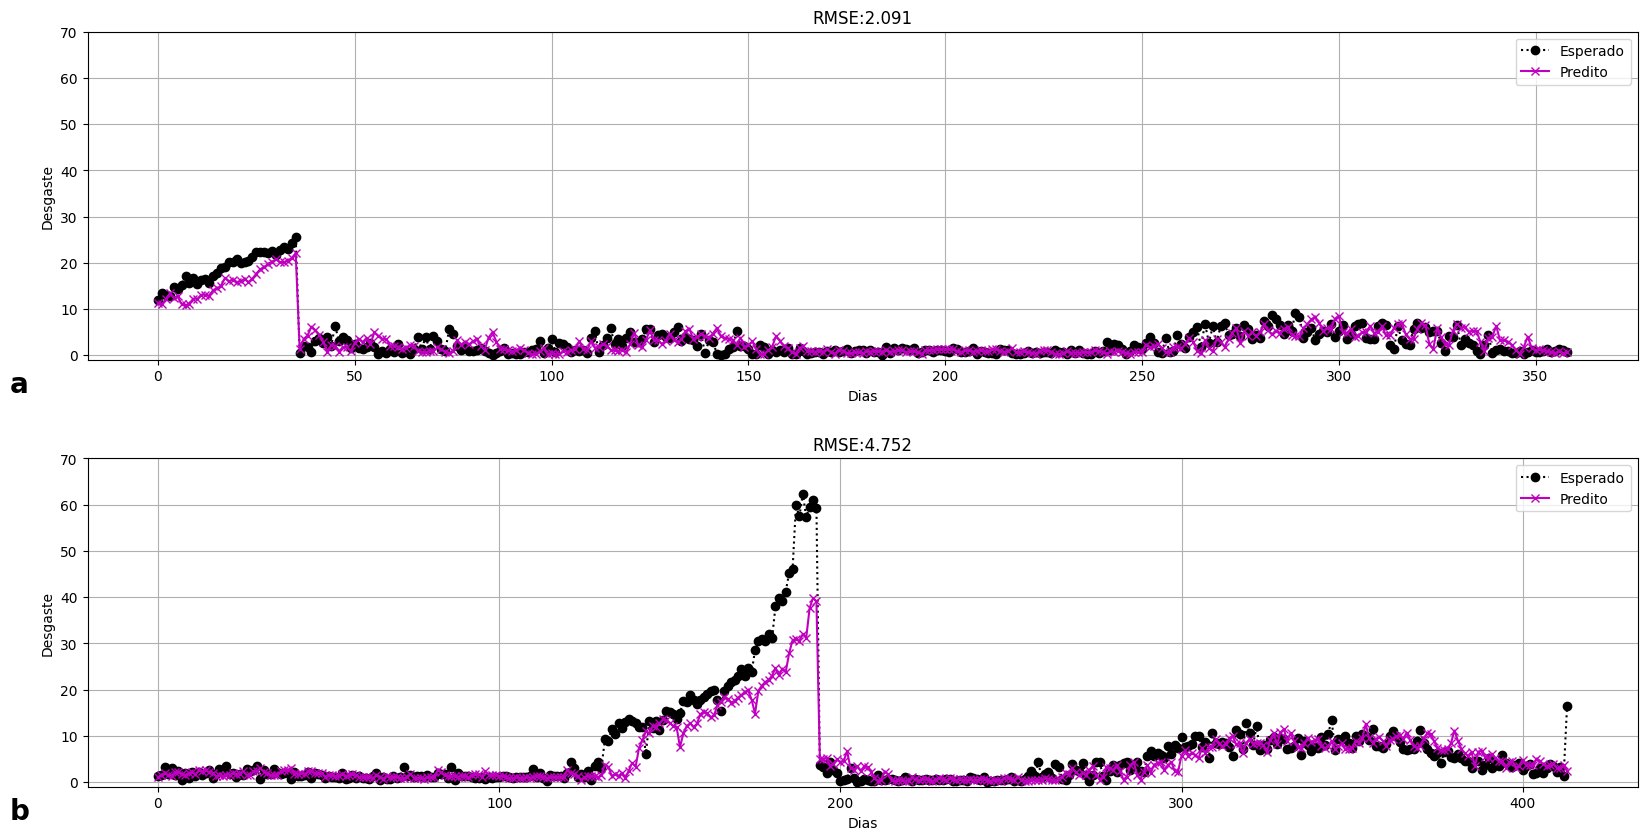

In [29]:
fig = plt.figure(figsize = (20,10),dpi=100)
axes = gridspec.GridSpec(nrows=2, ncols=1, figure=fig, wspace=0.2, hspace=0.3)
im = ['a','b']

np.diff(samples[:,look_back+10])

count = 0
for i in np.diff(samples[:,look_back+10]):
  # print (i)
  if i !=0:
    indice = count
  count = count+1


#plot do melhor modelo (9747)
ax = fig.add_subplot(axes[0])
ax.set_title("RMSE:"+ str(round(rmse(all_test[0:indice],all_pred[0:indice]),3)))
ax.grid()
ax.text(-0.05, -0.1, im[0], size=20, weight='bold', transform=ax.transAxes)
ax.plot(all_test[0:indice],':ok')
ax.plot(all_pred[0:indice],'-xm')
ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste")
ax.legend(["Esperado",'Predito'])

#plot do melhor modelo (9834)
ax = fig.add_subplot(axes[1])
ax.set_title("RMSE:"+ str(round(rmse(all_test[indice:-1],all_pred[indice:-1]),3)))
ax.grid()
ax.text(-0.05, -0.1, im[1], size=20, weight='bold', transform=ax.transAxes)
ax.plot(all_test[indice:-1],':ok')
ax.plot(all_pred[indice:-1],'-xm')
ax.set_ylim([-1,70])
ax.set_xlabel("Dias")
ax.set_ylabel("Desgaste")
ax.legend(["Esperado",'Predito'])

print(round(rmse(all_test[0:-1],all_pred[0:-1]),3))


# plt.savefig('resultados/fig_results_predict_f'+str(cod_falha)+'.pdf', format="pdf", dpi=1000, bbox_inches="tight")